In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Polynomial regression - LS vs MLE with K-fold cross validation

### Selecting model-order and Generating data
Here we will generate a synthetic dataset from a n-th order polynomial model **$y = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n $** and add some noise, with known distribution, to simulate sampling of the data, giving us **$y_{measured} = y + noise$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1,...,n}$ = model parameters   
$noise$ = measurement noise

Given the genreated input data $u$ and the measured data **$y_{measured}$** we will try to estimate the polynomial model coeffitienst $\hat{\theta}_{0,1,...,n}$ using the Least sqaures (LS) and Maximum likelihood estimate (MLE) methods.

### Model-order selection 
The "params" vector decides the order of the selected model, make sure to put in \$n+1\$ parameters into the vector for the get a model of order \$n\$, the first parameter \$\theta_0\$ is the bias term

In [10]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

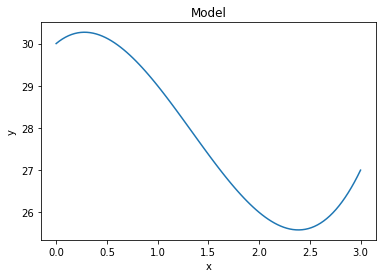

In [11]:
# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [30,2,-4,1]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=0, stop=3, num=100)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

### Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

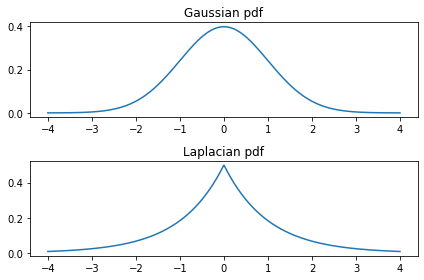

In [12]:
# Hyperparameters for the type of noise-generating distribution.
dist = "laplace"  # choose between "laplace" or "gauss"
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.2   # noise magnitude
N = 200           # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# The Gaussian probability density function:
# Also available in library "scipy.stats.norm"
def gauss_pdf(x, loc, scale):
    return 1.0/(scale * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - loc) / scale)**2 )

# Plot pdfs:
fig, [ax0, ax1] = plt.subplots(2)

n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf
ax0.plot(n, gauss_pdf(n, loc, scale))
ax0.set_title('Gaussian pdf')
ax1.plot(n,laplace_pdf(n, loc, scale))
ax1.set_title('Laplacian pdf')
plt.tight_layout()
plt.show()

### Data generation:

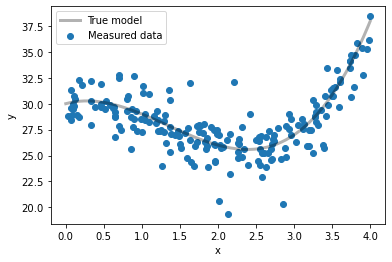

In [18]:
# Generate data points
range_low = 0
range_high = 4
u = np.sort(np.random.uniform(range_low,range_high,N))
y_true = y_model(u)

# Generate noise
from scipy.stats import norm, laplace
if dist == "laplace":
    #pdf = laplace_pdf
    pdf = laplace.pdf
    noise = magnitude * np.random.laplace(loc, scale, N)
elif dist == "gauss":
    #pdf = gauss_pdf
    pdf = norm.pdf
    noise = magnitude * np.random.normal(loc, scale, N)
else:
    raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")

# Add noise to the generated data points - thus simulating measurement
y = y_true + noise

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(0, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

In [8]:
import scipy.optimize as optimize

def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

def MLE_estimate(lik_func, measured_data, input_data, model_order, num_samples):
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(model_order+1)
    init_guess[-1] = num_samples

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = lik_func,
                                x0 = init_guess,
                                #options={'disp': True},
                                args = (measured_data, input_data))

    MLE_params = opt_res.x[:-1]
    #MLE_model = arbitrary_poly(MLE_params)
    
    return MLE_params

def LS_estimate(measured_data, input_data, model_order, num_samples):
    # Step 1
    # Matrix form
    u_tensor_0 = np.reshape(input_data,(num_samples,1))
    ones_vec = np.ones((num_samples,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

    for i in range(2,model_order):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    
    # Step 2
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
    
    # Step 3
    u_transpose_dot_y = np.dot(u_tensor.T, measured_data)  # calculating dot product
    
    # Step 4
    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    #LS_model = arbitrary_poly(LS_params)
    
    return LS_params

def f_format_3(num_array):
    return ["{:.3f}".format(round(i, 3)) for i in num_array]

## K-fold cross validation

Per fold RMSE:

MLE [2.227]
LS  [2.323] 

MLE [1.464]
LS  [1.416] 

MLE [2.092]
LS  [2.077] 

MLE [1.871]
LS  [1.866] 

MLE [1.996]
LS  [2.016] 

Average k-fold cross-validation RMSE:
MLE [1.930]
LS  [1.940] 

Validation RMSE:
MLE [2.177]
LS  [2.206] 



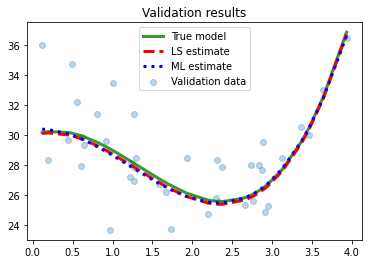

In [9]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import train_test_split as two_way_split

# Set up the K-fold splitting function and choose number of foldes 5-10 is recommended
n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True, random_state=1)

# Split the data into train/test & validate sets
u_rest, u_val, y_rest, y_val = two_way_split(u, y, test_size=0.2, random_state=5)

# Empty arrays for avg RMSE calculation
MLE_RMSE_sum = np.zeros(1)
LS_RMSE_sum = np.zeros(1)

# K-fold slicing loop
print("Per fold RMSE:\n")
for train_index, test_index in kf.split(u_rest):
    X_train, X_test = u[train_index], u[test_index]
    y_train, y_test = y[train_index], y[test_index]
    MLE_params = MLE_estimate(lik_func=log_lik, 
                              measured_data=y_train, 
                              input_data=X_train, 
                              model_order=len(true_params), 
                              num_samples=len(X_train))
    
    LS_params = LS_estimate(measured_data=y_train, 
                            input_data=X_train, 
                            model_order=len(true_params), 
                            num_samples=len(X_train))
    
    # Creaste k-fold sub-model
    MLE_sub_model = arbitrary_poly(MLE_params)
    LS_sub_model = arbitrary_poly(LS_params)
    
    # Calculate the RMSE of the sub-model
    MLE_RMSE = np.sqrt(np.mean((MLE_sub_model(X_test)-y_test)**2))
    LS_RMSE = np.sqrt(np.mean((LS_sub_model(X_test)-y_test)**2))
    
    # Sum the RMSE for avg RMSE calculation
    MLE_RMSE_sum += MLE_RMSE
    LS_RMSE_sum += LS_RMSE
    
    print("MLE [%.3f]" % (MLE_RMSE))
    print("LS  [%.3f]" % (LS_RMSE),"\n")

    
# Calculate the avg RMSE error
print("Average k-fold cross-validation RMSE:")
print("MLE [%.3f]" % (MLE_RMSE_sum/n_splits))
print("LS  [%.3f]" % (LS_RMSE_sum/n_splits), "\n")


# Define the models using training and test data and test them using the validation set
MLE_params = MLE_estimate(lik_func=log_lik, 
                          measured_data=y_rest, 
                          input_data=u_rest, 
                          model_order=len(true_params), 
                          num_samples=len(u_rest))

LS_params = LS_estimate(measured_data=y_rest, 
                        input_data=u_rest, 
                        model_order=len(true_params), 
                        num_samples=len(u_rest))

MLE_model = arbitrary_poly(MLE_params)
LS_model = arbitrary_poly(LS_params)

# Re-sort the data in case shuffeled (for plotting)
u_val_sorted = np.sort(u_val)

# Valdiate the models using validation sets 
MLE_RMSE_val = np.sqrt(np.mean((MLE_model(u_val)-y_val)**2))
LS_RMSE_val = np.sqrt(np.mean((LS_model(u_val)-y_val)**2))

print("Validation RMSE:")
print("MLE [%.3f]" % (MLE_RMSE_val))
print("LS  [%.3f]" % (LS_RMSE_val),"\n")

plt.figure()
plt.scatter(u_val, y_val, alpha=0.3, label=r"Validation data")
plt.plot(u_val_sorted, y_model(u_val_sorted), "g", alpha=0.8, lw=3, label="True model")
plt.plot(u_val_sorted, LS_model(u_val_sorted), "r--",  lw=3, label="LS estimate")
plt.plot(u_val_sorted, MLE_model(u_val_sorted), "b:",  lw=3, label="ML estimate")
plt.title("Validation results")
plt.legend();